In [119]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA

# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline

'''
Demo from 
https://github.com/akcarsten/Independent_Component_Analysis
'''

'\nDemo from \nhttps://github.com/akcarsten/Independent_Component_Analysis\n'

In [66]:
np.random.seed(23)

# Number of samples
ns = np.linspace(0, 200, 1000)

# Source matrix
S = np.array([np.sin(ns * 1),
              signal.sawtooth(ns * 1.9),
              np.random.random(len(ns))]).T

# Mixing matrix
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])

# Mixed signal matrix
X = S.dot(A).T

In [68]:
X.shape

(3, 1000)

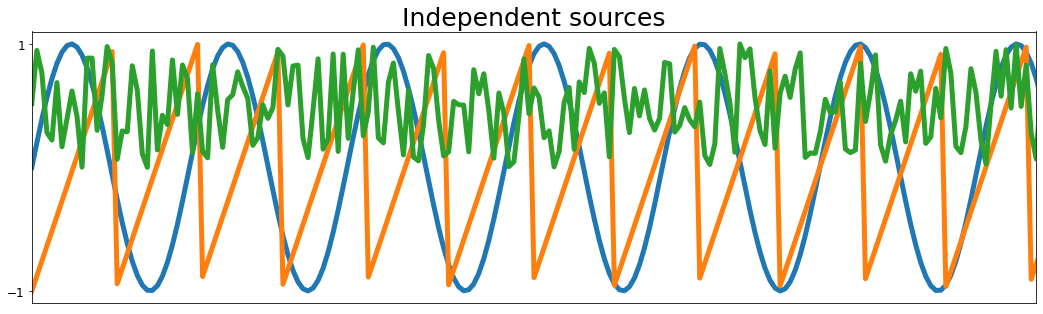

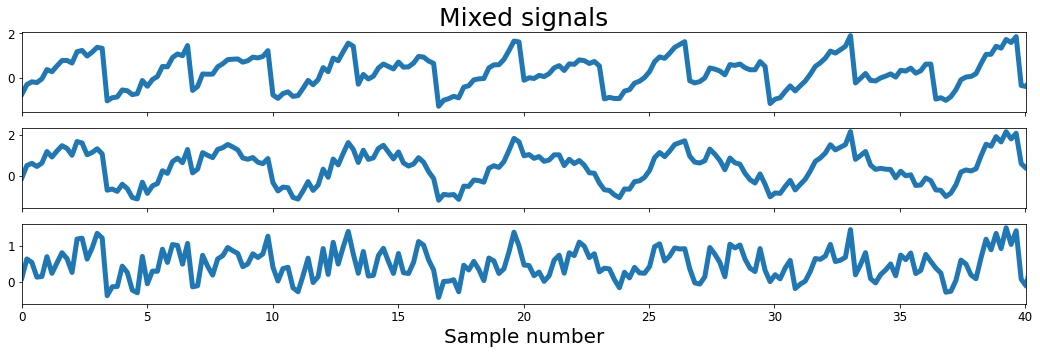

In [3]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(ns, S, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[200])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(ns, X[0], lw=5)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(ns, X[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(ns[0], ns[-1])

ax[2].plot(ns, X[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(ns[0], ns[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(ns[0], ns[200])

plt.show()

In [4]:
# Define two non-gaussian uniform components
s1 = np.random.rand(1000)
s2 = np.random.rand(1000)
s = np.array(([s1, s2]))

# Define two gaussian components
s1n = np.random.normal(size=1000)
s2n = np.random.normal(size=1000)
sn = np.array(([s1n, s2n]))

# Define orthogonal mixing matrix
A = np.array(([0.96, -0.28],[0.28, 0.96]))

# Mix signals
mixedSignals = s.T.dot(A)
mixedSignalsN = sn.T.dot(A)

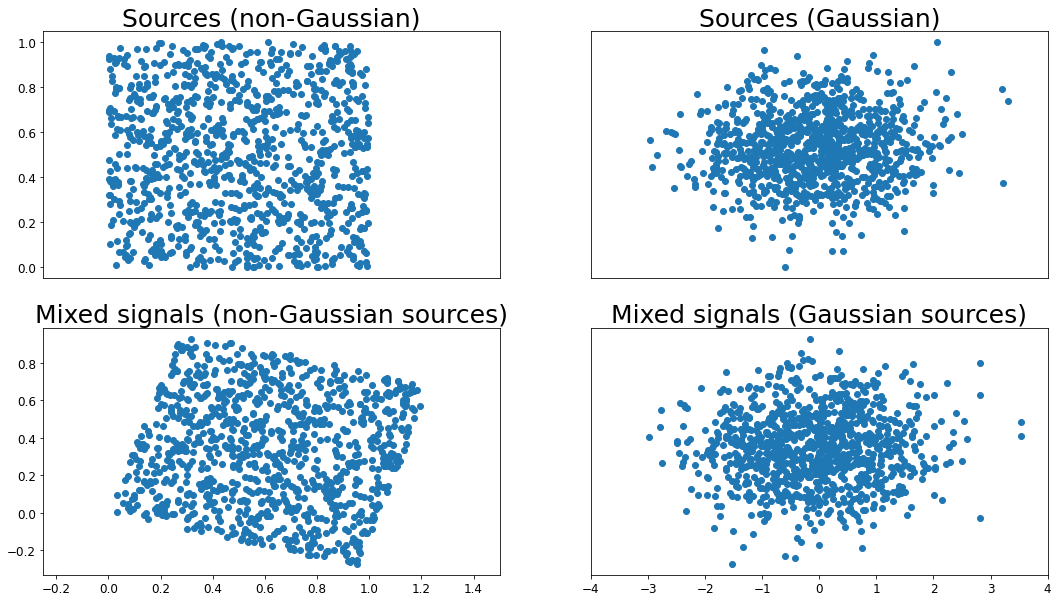

In [5]:
# Plot results
fig, ax = plt.subplots(2, 2, figsize=[18, 10])
ax[0][0].scatter(s[0], s[1])
ax[0][0].tick_params(labelsize=12)
ax[0][0].set_title('Sources (non-Gaussian)', fontsize=25)
ax[0][0].set_xlim([-0.25, 1.5])
ax[0][0].set_xticks([])

ax[0][1].scatter(sn[0], sn[1])
ax[0][1].tick_params(labelsize=12)
ax[0][1].set_title('Sources (Gaussian)', fontsize=25)
ax[0][1].set_xlim([-4, 4])
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

ax[1][0].scatter(mixedSignals.T[0], mixedSignals.T[1])
ax[1][0].tick_params(labelsize=12)
ax[1][0].set_title('Mixed signals (non-Gaussian sources)', fontsize=25)
ax[1][0].set_xlim([-0.25, 1.5])

ax[1][1].scatter(mixedSignalsN.T[0], mixedSignalsN.T[1])
ax[1][1].tick_params(labelsize=12)
ax[1][1].set_title('Mixed signals (Gaussian sources)', fontsize=25)
ax[1][1].set_xlim([-4, 4])
ax[1][1].set_yticks([])

plt.show()

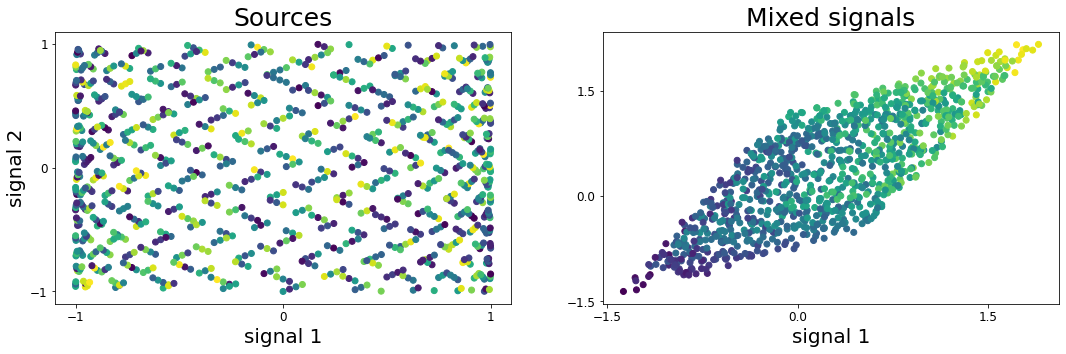

In [6]:
fig, ax = plt.subplots(1, 2, figsize=[18, 5])
ax[0].scatter(S.T[0], S.T[1], c=S.T[2])
ax[0].tick_params(labelsize=12)
ax[0].set_yticks([-1, 0, 1])
ax[0].set_xticks([-1, 0, 1])
ax[0].set_xlabel('signal 1', fontsize=20)
ax[0].set_ylabel('signal 2', fontsize=20)
ax[0].set_title('Sources', fontsize=25)

ax[1].scatter(X[0], X[1], c=X[2])
ax[1].tick_params(labelsize=12)
ax[1].set_yticks([-1.5, 0, 1.5])
ax[1].set_xticks([-1.5, 0, 1.5])
ax[1].set_xlabel('signal 1', fontsize=20)
ax[1].set_title('Mixed signals', fontsize=25)
plt.show()

In [8]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean
    return centered, mean

In [9]:
def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

In [10]:
def whiten(x):
    # Calculate the covariance matrix
    coVarM = covariance(X)

    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)

    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))

    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))

    # Project onto whitening matrix
    Xw = np.dot(whiteM, X)

    return Xw, whiteM

In [11]:
def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=5000):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):

                # Dot product of weight and signal
                ws = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                wg = np.tanh(ws * alpha).T

                # Pass w*s into g prime
                wg_ = (1 - np.square(np.tanh(ws))) * alpha

                # Update weights
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights              
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)

                # Update weights
                w = wNew

                # Update counter
                i += 1

            W[c, :] = w.T
    return W

In [12]:
# Center signals
Xc, meanX = center(X)

# Whiten mixed signals
Xw, whiteM = whiten(Xc)

In [23]:
print(np.round(covariance(Xw)),'\n')
print(Xc,'\n')
print(meanX,'\n')

[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]] 

[[-0.97742316 -0.5420792  -0.416291   ... -0.95822596 -0.73631901
  -0.3993731 ]
 [-0.46773411  0.13540262  0.24166133 ... -1.42300223 -1.19286108
  -0.7710459 ]
 [-0.3581479   0.15972146  0.06483447 ... -0.66941336 -0.45243258
  -0.03582074]] 

[[0.23607211]
 [0.38157241]
 [0.47544578]] 



In [14]:
W = fastIca(Xw,  alpha=1)

#Un-mix signals using
unMixed = Xw.T.dot(W.T)

# Subtract mean
unMixed = (unMixed.T - meanX).T

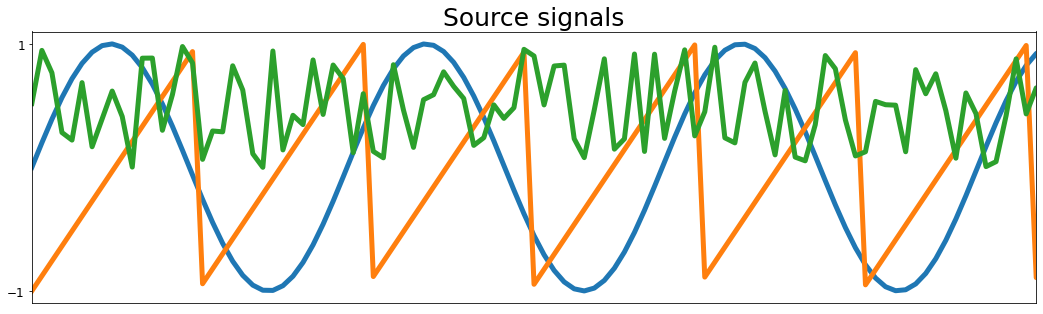

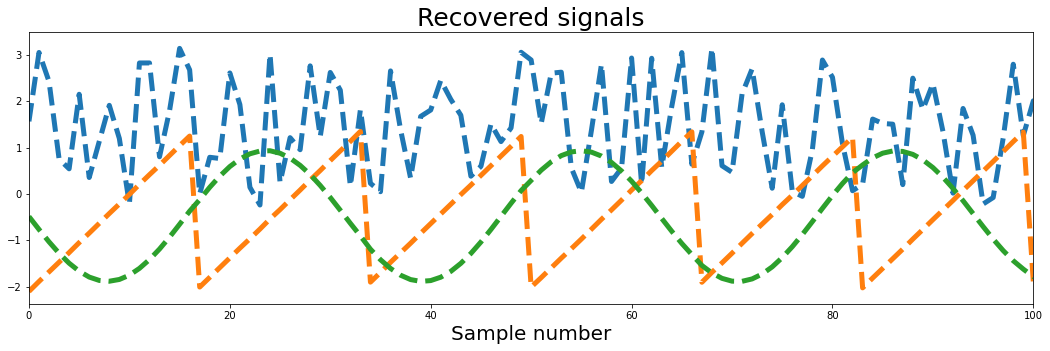

In [15]:
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(unMixed, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()

In [24]:
def kurt(x):
    n = np.shape(x)[0]
    mean = np.sum((x**1)/n) # Calculate the mean
    var = np.sum((x-mean)**2)/n # Calculate the variance
    skew = np.sum((x-mean)**3)/n # Calculate the skewness
    kurt = np.sum((x-mean)**4)/n # Calculate the kurtosis
    kurt = kurt/(var**2)-3

    return kurt, skew, var, mean

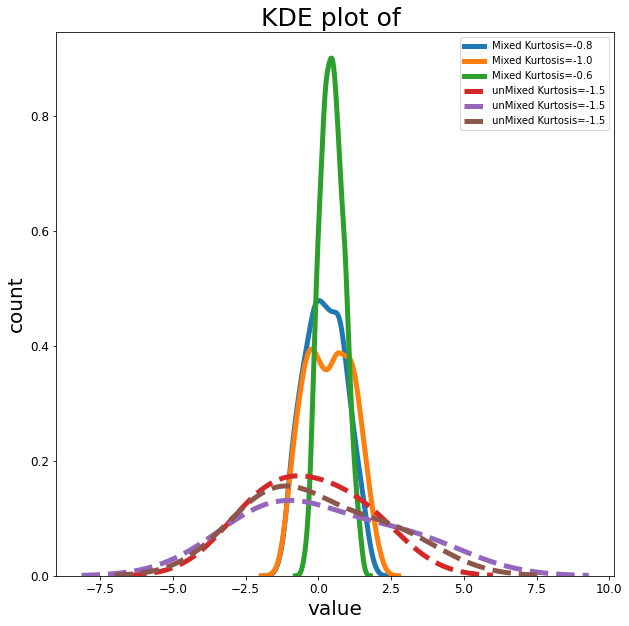

In [26]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i in range(X.shape[0]):

    sns.kdeplot(X[i, :], lw=5, label='Mixed Kurtosis={}'.format(np.round(kurt(X[i, :])[0], decimals=1)))

for i in range(X.shape[0]):   
    sns.kdeplot(unMixed[i, :], lw=5, ls='--', label='unMixed Kurtosis={}'.format(np.around(kurt(unMixed[i, :])[0], decimals=1)))

ax.tick_params(labelsize=12)
ax.set_xlabel('value', fontsize=20)
ax.set_ylabel('count', fontsize=20)
ax.set_title('KDE plot of ', fontsize=25)
plt.legend()
plt.show()

# Implement on real data

In [30]:
df = pd.read_csv('cbsa_data_(k,M,f,h,s,p).csv')
df = df[['GTCBSA', 'ALL_fpll', 'SOCIAL_fpll', 'CARE_fpll',
        'CBSA_c2_workplace_closing',
        'CBSA_c6_stay_at_home_requirements',
        'CBSA_c1_school_closing','stayed_home_wave2', 'stayed_home_wave3', 
        'tiles_visited_wave2',
        'tiles_visited_wave3', 'percent_traveling_2019_w2',
        'trips_per_traveler_2019_w2', 'trips_<25_per_traveler_2019_w2',
        'percent_traveling_2019_w3', 'trips_per_traveler_2019_w3',
        'trips_<25_per_traveler_2019_w3', 'percent_traveling_2020_w2',
        'trips_per_traveler_2020_w2', 'trips_<25_per_traveler_2020_w2',
        'percent_traveling_2020_w3', 'trips_per_traveler_2020_w3',
        'trips_<25_per_traveler_2020_w3', 'community_wfh_score',
        'percent_travel_ratio_w2', 'percent_travel_ratio_w3',
        'trips_per_traveler_ratio_w2', 'trips_per_traveler_ratio_w3',
        'trips_<25_per_traveler_ratio_w2', 'trips_<25_per_traveler_ratio_w3']]

In [76]:
df = df[~df['community_wfh_score'].isna()]
df = df[df['ALL_fpll']>0]
df

GTCBSA  ALL_fpll  SOCIAL_fpll  CARE_fpll  CBSA_c2_workplace_closing  \
2     10180  0.231019     0.212377   0.048661                   1.983673   
5     10420  0.248605     0.227051   0.015763                   1.583673   
9     10580  0.189253     0.157915   0.032236                   2.502041   
13    10740  0.223659     0.168799   0.052871                   2.122449   
17    10900  0.195679     0.143984   0.050736                   1.692556   
..      ...       ...          ...        ...                        ...   
878   49020  0.172942     0.123191   0.050513                   1.253819   
881   49180  0.359290     0.324430   0.125245                   2.000000   
889   49620  0.246115     0.178572   0.055659                   1.673469   
890   49660  0.360707     0.327637   0.093767                   1.602154   
892   49740  0.345677     0.286611   0.077989                   1.718367   

     CBSA_c6_stay_at_home_requirements  CBSA_c1_school_closing  \
2                             1.093878                2.375510   
5                             1.253061                2.583673   
9                             1.155102                2.497959   
13                            1.000000                2.440816   
17                            1.150079                2.452165   
..                                 ...                     ...   
878                           1.110564                2.476168   
881                           1.114286                2.412245   
889                           1.142857                2.440816   
890                           1.230380                2.554272   
892                           1.061224                2.453061   

     stayed_home_wave2  stayed_home_wave3  tiles_visited_wave2  ...  \
2             0.173611           0.174781            -0.044443  ...   
5             0.196214           0.214358            -0.004947  ...   
9             0.212604           0.223464            -0.057622  ...   
13            0.204399           0.225125            -0.103691  ...   
17            0.210570           0.219807            -0.064671  ...   
..                 ...                ...                  ...  ...   
878           0.186385           0.197217            -0.034551  ...   
881           0.199749           0.201573            -0.077559  ...   
889           0.197799           0.209481            -0.032111  ...   
890           0.189617           0.210899             0.040098  ...   
892           0.233599           0.197853            -0.182843  ...   

     percent_traveling_2020_w3  trips_per_traveler_2020_w3  \
2                     0.722977                    3.717278   
5                     0.721359                    4.106143   
9                     0.709173                    4.867789   
13                    0.714990                    4.283598   
17                    0.719221                    4.033419   
..                         ...                         ...   
878                   0.744574                    3.721923   
881                   0.746747                    3.900829   
889                   0.739319                    3.941143   
890                   0.723747                    4.278466   
892                   0.634929                    3.434684   

     trips_<25_per_traveler_2020_w3  community_wfh_score  \
2                          3.437942             2.918824   
5                          3.810285             2.906846   
9                          4.512013             2.440149   
13                         3.976312             2.728131   
17                         3.631342             2.955963   
..                              ...                  ...   
878                        3.188121             3.053790   
881                        3.538598             3.026663   
889                        3.561941             3.092925   
890                        3.922773             3.218160   
892                        3.226359      

In [77]:
df_string = df[['GTCBSA', 'ALL_fpll', 'SOCIAL_fpll', 'CARE_fpll']]
df_mob = df[['CBSA_c2_workplace_closing',
        'CBSA_c6_stay_at_home_requirements',
        'CBSA_c1_school_closing','stayed_home_wave2', 'stayed_home_wave3', 
        'tiles_visited_wave2',
        'tiles_visited_wave3', 'percent_traveling_2019_w2',
        'trips_per_traveler_2019_w2', 'trips_<25_per_traveler_2019_w2',
        'percent_traveling_2019_w3', 'trips_per_traveler_2019_w3',
        'trips_<25_per_traveler_2019_w3', 'percent_traveling_2020_w2',
        'trips_per_traveler_2020_w2', 'trips_<25_per_traveler_2020_w2',
        'percent_traveling_2020_w3', 'trips_per_traveler_2020_w3',
        'trips_<25_per_traveler_2020_w3', 'community_wfh_score',
        'percent_travel_ratio_w2', 'percent_travel_ratio_w3',
        'trips_per_traveler_ratio_w2', 'trips_per_traveler_ratio_w3',
        'trips_<25_per_traveler_ratio_w2', 'trips_<25_per_traveler_ratio_w3']]

X = df_mob.to_numpy().T
Y = [i for i in range(len(X))]
Y = np.array(Y).reshape(-1,1)

In [78]:
X.shape

(26, 243)

In [79]:
# Center signals
Xc, meanX = center(X)

# Whiten mixed signals
Xw, whiteM = whiten(Xc)

W = fastIca(Xw,  alpha=1)

#Un-mix signals using
unMixed = Xw.T.dot(W.T)

# Subtract mean
unMixed = (unMixed.T - meanX).T

In [81]:
unMixed.shape

(243, 26)

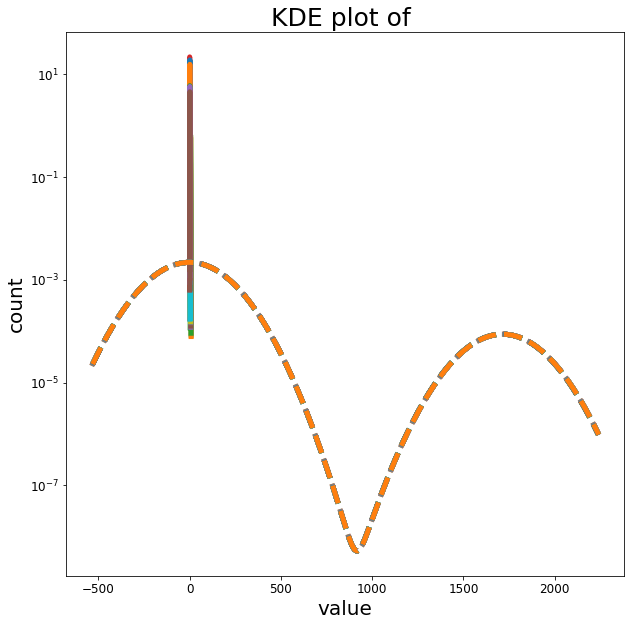

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i in range(X.shape[0]):

    sns.kdeplot(X[i, :], lw=5, label='Mixed Kurtosis={}'.format(np.round(kurt(X[i, :])[0], decimals=1)))

for i in range(X.shape[0]):   
    sns.kdeplot(unMixed[i, :], lw=5, ls='--', label='unMixed Kurtosis={}'.format(np.around(kurt(unMixed[i, :])[0], decimals=1)))

ax.tick_params(labelsize=12)
ax.set_xlabel('value', fontsize=20)
ax.set_ylabel('count', fontsize=20)
ax.set_title('KDE plot of ', fontsize=25)
#plt.legend()
plt.yscale('log')
plt.show()

In [112]:
#X[0].shape
unX = unMixed.T
unX[0].shape
df_string['ALL_fpll'].shape

for i in range(len(X)):
    ro = stats.spearmanr(X[i], df_string['ALL_fpll'])
    if ro[1] <= 0.05:
        print(i, ro[0], ro[1])

print()

for i in range(len(unX)):
    ro = stats.spearmanr(unX[i], df_string['ALL_fpll'])
    if ro[1] <= 0.05:
        print(i, ro[0], ro[1])


1 -0.15965687233027448 0.012703427023060727
5 0.18685781477634433 0.0034600955511484865
6 0.20480680291907316 0.0013261611209603786
14 0.14589427977406116 0.022922447807346775
15 0.14858052289746276 0.020499683056893453
18 0.12776213869110042 0.04664538686118189
19 0.15730161358576658 0.014098370227778646
20 0.16885697511628955 0.008349154473744931
21 0.14531304099113337 0.023478050758603382
22 0.13254753195140676 0.03895364951545949
24 0.1350012795616372 0.035444059692237205

11 0.12664398580941055 0.048615097144217516
17 0.12822378445826035 0.04585185911821237
18 -0.14388963320905696 0.024887957093092588


# ICA is a fail
It correlates less with f than the raw data. 

# Next up: PCA

In [130]:
Xc.shape # centered data

pca = PCA()
pca.fit(Xc.T)
Xc_PCA = pca.transform(Xc.T)

Xc_PCA = Xc_PCA.T

for i in range(len(Xc_PCA)):
    ro = stats.spearmanr(Xc_PCA[i], df_string['ALL_fpll'])
    if ro[1] <= 0.05:
        print(i, ro[0], ro[1])


2 0.1280180510185478 0.04620408949199416
11 -0.13453628853529498 0.036087744545418736
15 -0.13071014834551842 0.04176988036866678
17 -0.1310639095040486 0.041214722185993674


# PCA is also a fail